<a href="https://colab.research.google.com/github/nazrana-nahreen/-Online-Exam-System/blob/main/Postpartum_Depression_Prediction_in_Bangladesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
# Load data
data = pd.read_csv('/content/PPD_dataset_v2.csv')

# Define binary target: 1 if EPDS Result is "High"
data['PPD_risk'] = (data['EPDS Result'] == 'High').astype(int)

# Drop columns not needed for modeling
drop_cols = ['sr', 'PHQ9 Score', 'PHQ9 Result', 'EPDS Score', 'EPDS Result']
X = data.drop(columns=drop_cols + ['PPD_risk'])
y = data['PPD_risk']

# Identify numeric and categorical columns
numeric_features = ['Age', 'Number of the latest pregnancy']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocessing: scale numeric, encode categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Define pipelines for Logistic Regression and Random Forest
pipelines = {
    'Logistic Regression': Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
    'Random Forest': Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
}

# Train and evaluate each model
for name, model in pipelines.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, preds))


Logistic Regression Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.77      0.78      0.77        90
           1       0.71      0.70      0.71        70

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160

Random Forest Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        90
           1       0.78      0.70      0.74        70

    accuracy                           0.78       160
   macro avg       0.78      0.77      0.77       160
weighted avg       0.78      0.78      0.78       160



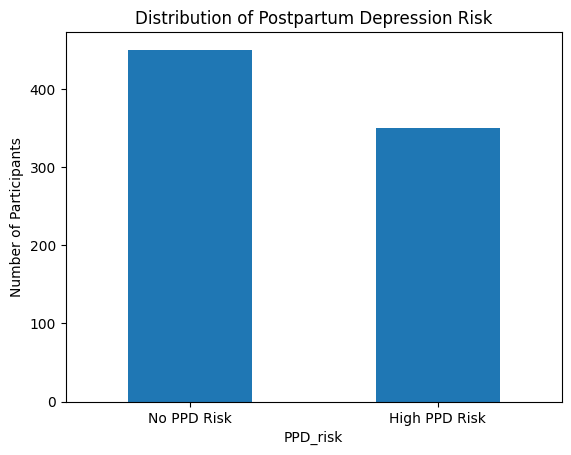

In [ ]:
import matplotlib.pyplot as plt

y.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No PPD Risk', 'High PPD Risk'], rotation=0)
plt.ylabel('Number of Participants')
plt.title('Distribution of Postpartum Depression Risk')
plt.show()


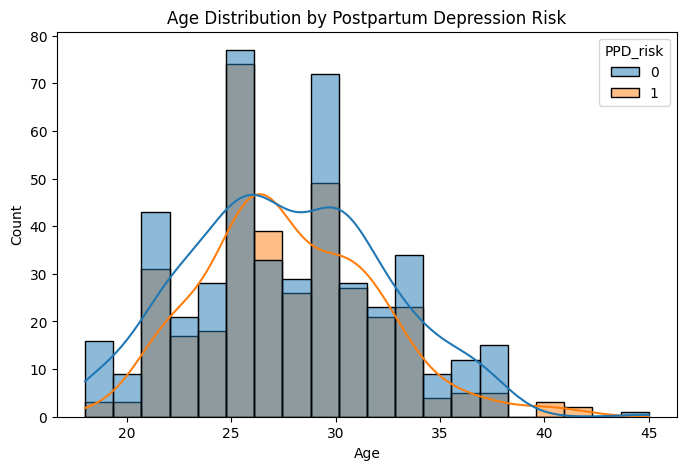

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(data=data, x='Age', hue='PPD_risk', bins=20, kde=True)
plt.title('Age Distribution by Postpartum Depression Risk')
plt.show()


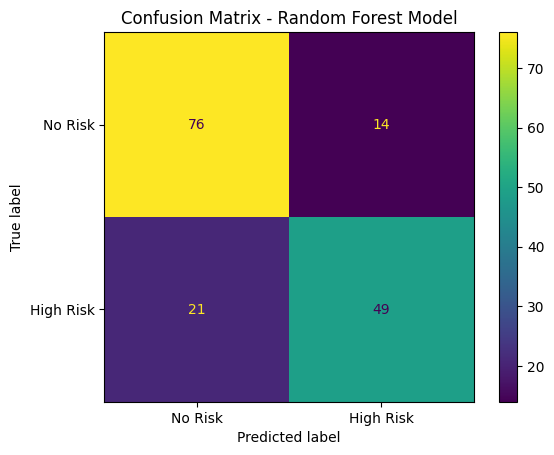

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = pipelines['Random Forest'].predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Risk', 'High Risk'])
disp.plot()
plt.title("Confusion Matrix - Random Forest Model")
plt.show()


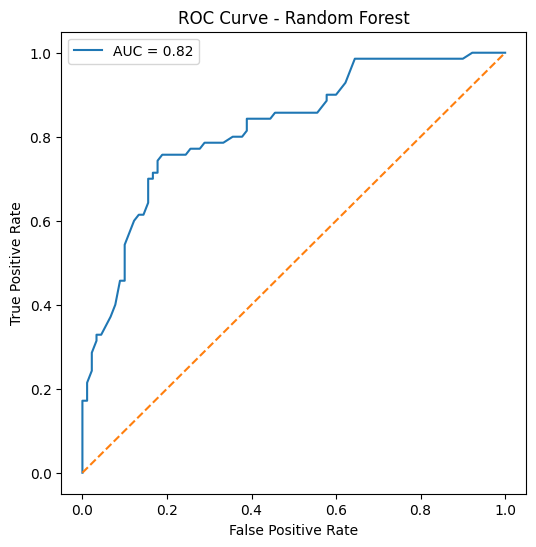

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = pipelines['Random Forest'].predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


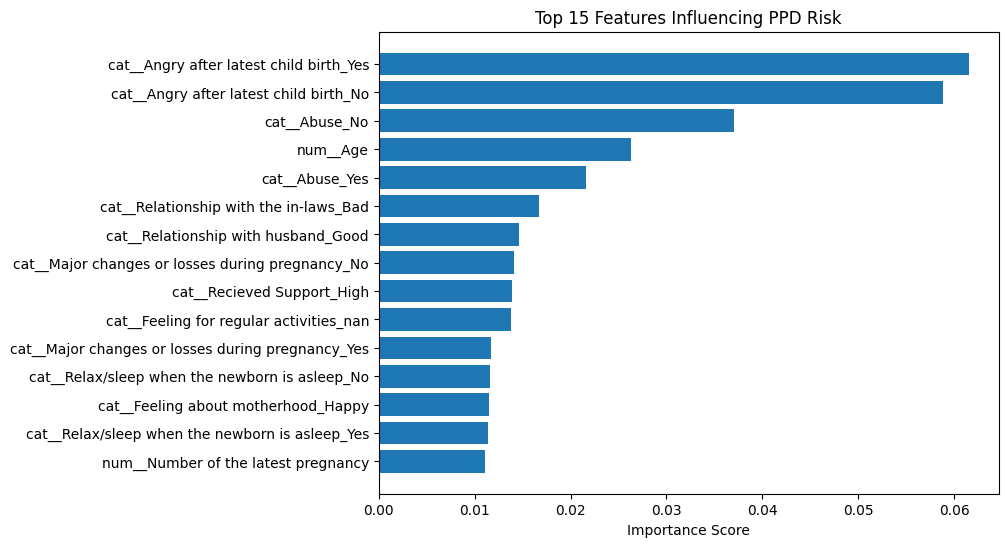

In [ ]:
import numpy as np

feature_names = pipelines['Random Forest'].named_steps['pre'].get_feature_names_out()
importances = pipelines['Random Forest'].named_steps['clf'].feature_importances_

indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 15 Features Influencing PPD Risk')
plt.show()


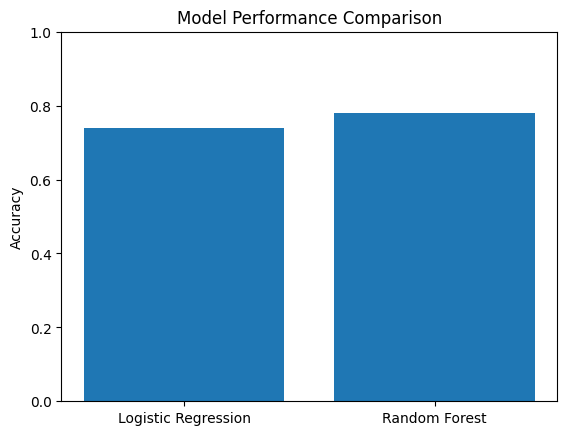

In [ ]:
models = ['Logistic Regression', 'Random Forest']
accuracies = [0.74, 0.78]

plt.bar(models, accuracies)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()


In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

xgb_model = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ))
])

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.74375
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        90
           1       0.74      0.64      0.69        70

    accuracy                           0.74       160
   macro avg       0.74      0.73      0.74       160
weighted avg       0.74      0.74      0.74       160



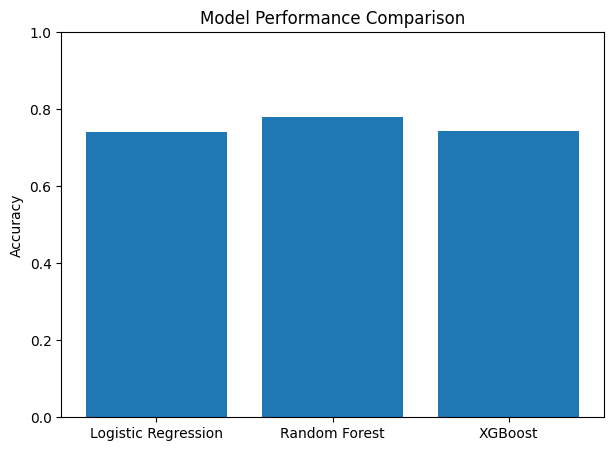

In [ ]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [
    0.74,
    0.78,
    accuracy_score(y_test, y_pred_xgb)
]

plt.figure(figsize=(7,5))
plt.bar(models, accuracies)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()


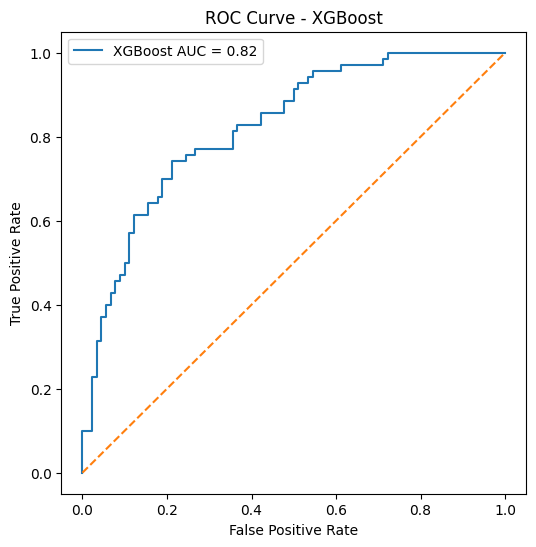

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'XGBoost AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()


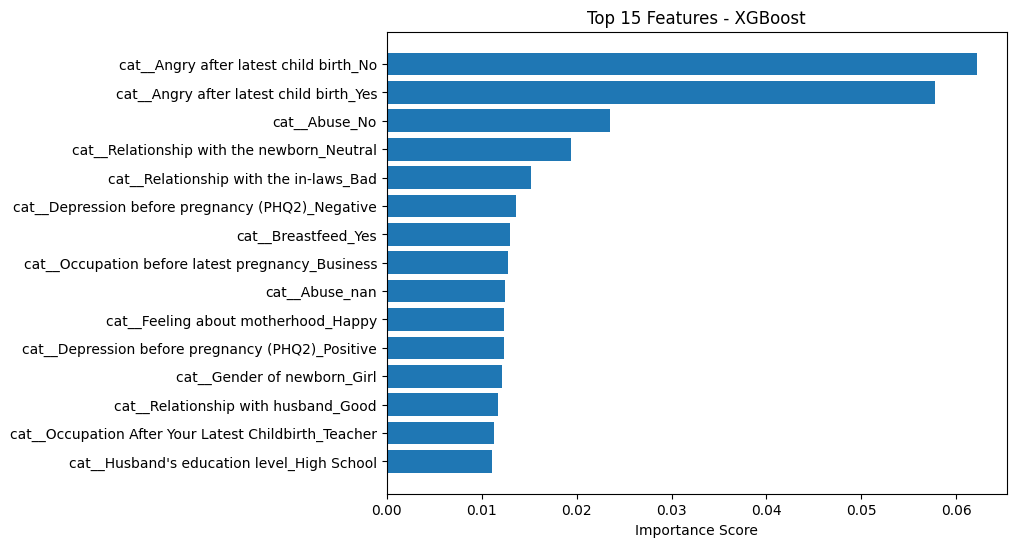

In [ ]:
import numpy as np

feature_names = xgb_model.named_steps['pre'].get_feature_names_out()
importances = xgb_model.named_steps['clf'].feature_importances_

indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 15 Features - XGBoost')
plt.show()
